#### Notebook for implementing and testing propagators

##### Imports and definitions

In [38]:
import numpy as np
import time as tm
import math
import scipy.constants as const
from pykern import pkcli
from pykern.pkcollections import PKDict

import srwlib
from srwlib import srwl
from srwlib import *

# from pulse import pulse
# import rslaser.pulse.pulse as pulse
# import srwl_uti_data as srwutil
# import rslaser.pulse as pulse
from rslaser.pulse import pulse as pulse
from rslaser.utils import srwl_uti_data as srwutil
from rslaser.optics import element as element
# import sys
#     # caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, '/../../rslaser/utils')


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
# plt.style.use('Solarize_Light2')
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 15}

##### Create laser pulse and extract fields

In [39]:
phE = 0.124    # photon energy [eV]
hc_ev_um = 1.23984198   # hc [eV*um]
phLambda = hc_ev_um / phE * 1e-6 # wavelength corresponding to phE in meters
print("Wavelength corresponding to %g keV: %g microns" %(phE * 1e-3, phLambda / 1e-6))

sigx_waist = 1e-3    # beam size at waist [m]
sigy_waist = 1e-3    # beam size at waist [m]

z_R_x = 4 * np.pi * sigx_waist**2 / phLambda    # horizontal Rayleigh range [m]
z_R_y = 4 * np.pi * sigy_waist**2 / phLambda    # verrtical Rayleigh range [m]
print(r'z_{R_x} = %g [m], z_{R_y} = %g [m]' %(z_R_x, z_R_y))

sig_s = z_R_x
tau_fwhm = sig_s / const.c * 2.355

Wavelength corresponding to 0.000124 keV: 9.99873 microns
z_{R_x} = 1.2568 [m], z_{R_y} = 1.2568 [m]


In [40]:
# specify parameters
slice_params = PKDict(
    sigx_waist = sigx_waist,
    sigy_waist = sigy_waist,
    num_sig_trans = 24,
    nx_slice = 1000,
    ny_slice = 1000,
    pulseE = 0.001,
    poltype = 1,
    mx = 0,
    my = 0,
)

pulse_params = PKDict(
        nslice = 1,
        chirp = 0,
        phE = phE,
        num_sig_long = 4,
        dist_waist = 0,
        # tau_fwhm = 0.1 / const.c / math.sqrt(2.),
        tau_fwhm = tau_fwhm,
        slice_params = slice_params,
)

params = pulse_params.copy()

In [59]:
# create laser pulse
pulse_init = pulse.LaserPulse(params)

# create separate single laser slice
slice_init = pulse.LaserPulseSlice(0, params = pulse_params)

In [42]:
# slice_vals = np.arange(1, _LASER_PULSE_DEFAULTS['nslice'] + 1, 1)
# rmsx_vals = pulse_init.rmsvals()[0]
# rmsy_vals = pulse_init.rmsvals()[1]
# long_int_vals = pulse_init.intensity_vals()

In [43]:
# print('rmsx_vals: %s [mm]' %(np.multiply(rmsx_vals, 1e3)))
# print('rmsy_vals: %s [mm]' %(np.multiply(rmsy_vals, 1e3)))

In [44]:
# fig = plt.figure(figsize = (10, 7))
# ax = fig.gca()

# ax.plot(slice_vals, rmsx_vals, 'r.-', label = r'$\sigma_x$')
# ax.plot(slice_vals, rmsy_vals, 'b.--',  label = r'$\sigma_y$')
# ax.get_xaxis().get_major_formatter().set_useOffset(False)
# # plt.xlim(0,350)
# # plt.ylim(0,100)
# plt.title('transverse rms sizes by slice')
# plt.xlabel('slice no.')
# plt.ylabel('rms size [m]')
# plt.legend()

In [45]:
wfr0 = slice_init.wfr

In [46]:
# calculate phase, E field, and intensity from initial Gsn wavefront
int0, int0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=0, _det=None, _fname='', _pr=True)
phase0, phase0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=4, _det=None, _fname='', _pr=True)
re0, re0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=5, _det=None, _fname='', _pr=True)
im0, im0_mesh = srwutil.calc_int_from_wfr(wfr0, _pol=0, _int_type=6, _det=None, _fname='', _pr=True)

Extracting intensity and saving it to a file ... completed (lasted 0.13 s)
Extracting intensity and saving it to a file ... completed (lasted 0.1 s)
Extracting intensity and saving it to a file ... completed (lasted 0.08 s)
Extracting intensity and saving it to a file ... completed (lasted 0.08 s)


In [47]:
# reshape into 2D Gsn phase, E field, and intensity arrays
int0_2d = np.array(int0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
phase0_2d = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
re0_2d = np.array(re0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
im0_2d = np.array(im0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
print('Size of initial mesh (coordinate):',np.shape(int0_2d))

Size of initial mesh (coordinate): (1000, 1000)


In [48]:
# create corresponding x and y arrays for 2D Gsn phase, E field, and intensity arrays
xvals_gsn_init=np.linspace(wfr0.mesh.xStart,wfr0.mesh.xFin,wfr0.mesh.nx)
yvals_gsn_init=np.linspace(wfr0.mesh.yStart,wfr0.mesh.yFin,wfr0.mesh.ny)

In [49]:
# calculate E field total from Re(E) and Im(E)
E_field_gsn_init = re0_2d + np.multiply(im0_2d, 1j)

Text(0.5, 1.0, 'Initial Wavefront Intensity')

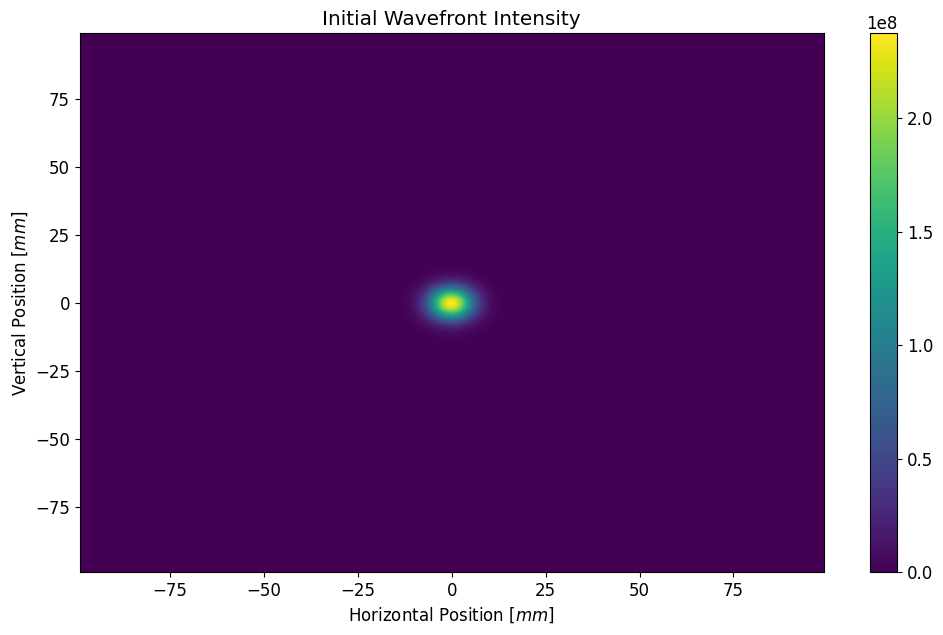

In [50]:
# plot initial intensity
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Intensity')

Text(0.5, 1.0, 'Initial Wavefront Re(E)')

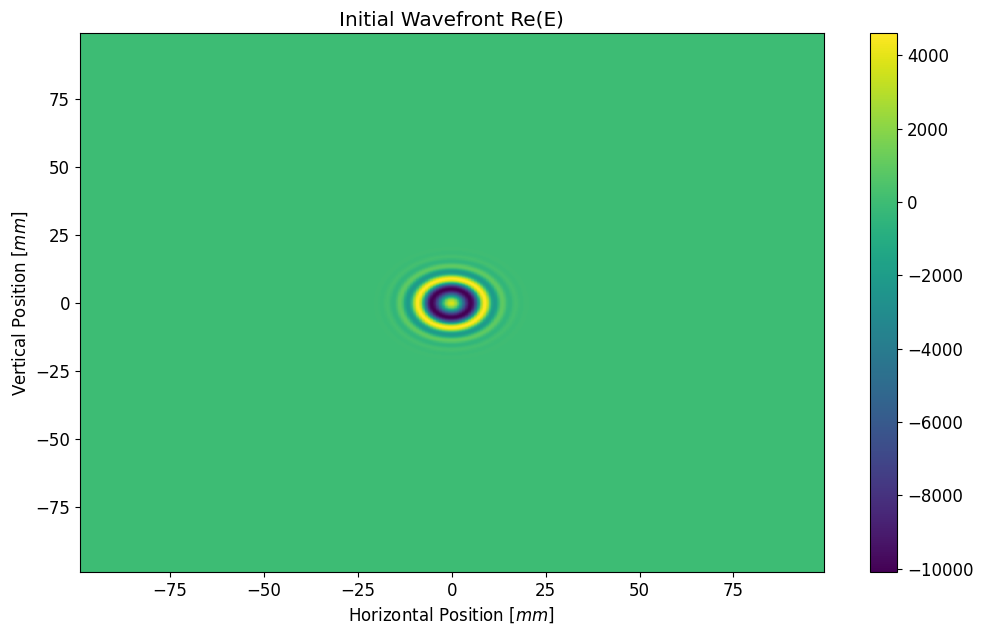

In [51]:
# plot initial Re(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), re0_2d, cmap=plt.cm.viridis, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Re(E)')

Text(0.5, 1.0, 'Initial Wavefront Im(E)')

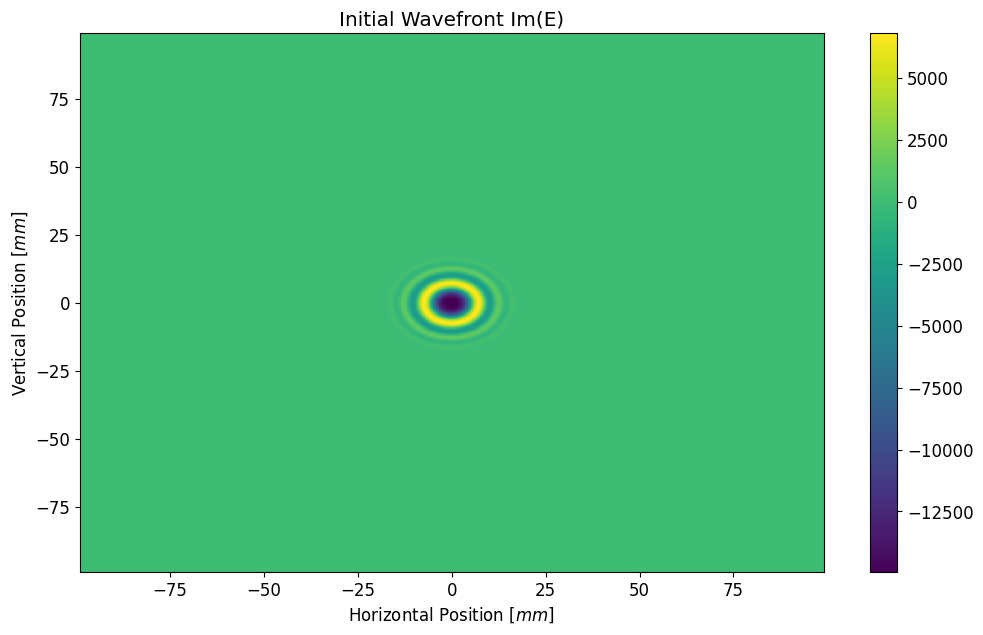

In [52]:
# plot initial Im(E)
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), im0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), im0_2d, cmap = plt.cm.get_cmap('cool'), shading='auto')
plt.colorbar()

cmap = plt.cm.get_cmap('Reds')

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)

ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Im(E)')

Text(0.5, 1.0, 'Initial Wavefront Phase')

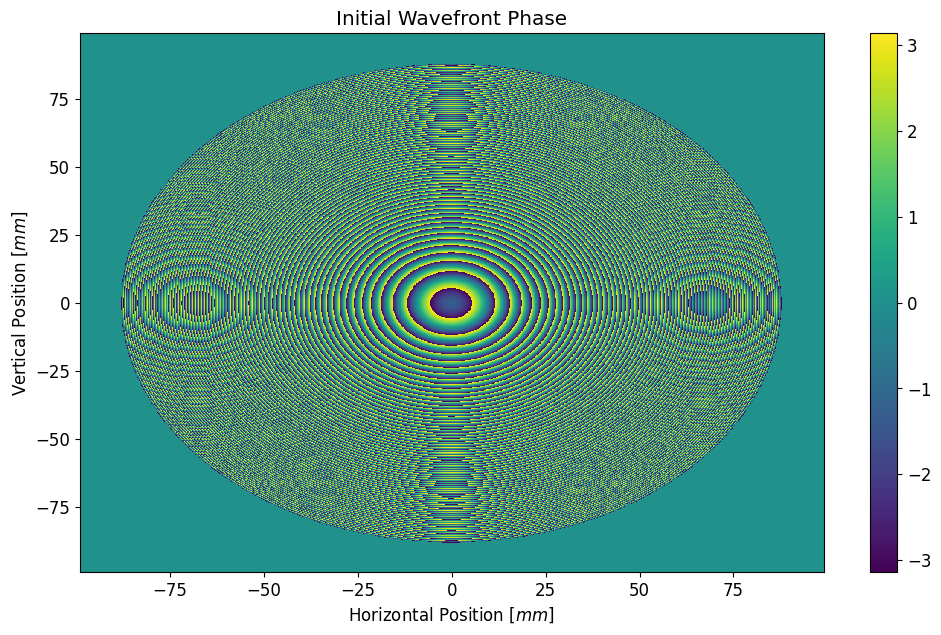

In [53]:
# plot initial phase
fig = plt.figure(figsize=(12,7))
ax = fig.gca()

plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), phase0_2d, cmap=plt.cm.viridis, shading='auto')
# plt.pcolormesh(np.multiply(xvals_gsn_init,1e3), np.multiply(yvals_gsn_init,1e3), int0_2d, cmap = Beach, shading='auto')
plt.colorbar()

# ax.set_ylim(-45, 45)
# ax.set_xlim(-45, 45)
ax.set_ylabel(r'Vertical Position [$mm$]')
ax.set_xlabel(r'Horizontal Position [$mm$]')
ax.set_title('Initial Wavefront Phase')

##### Create crystal element

In [56]:
n0 = 1.76            # n0
n2 = 2               # n2 [1/m^2]
len_cryst = 0.025    # crystal length [m]
nslice_cryst = 1     # no. of crystal slices


crystal_params = PKDict(
        n0 = n0,
        n2 = n2,
        length = len_cryst,
        nslice = nslice_cryst,
)

# params = pulse_params.copy()

crystal = [(element.Crystal(crystal_params), 'abcd')]

In [60]:
element.Crystal(crystal_params).propagate(pulse_init, 'abcd')

Propagated pulse slice  1  of  1
